# Loading libraries

In [1]:
import numpy as np
import pandas as pd

import os
import random
import optuna

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve,balanced_accuracy_score,f1_score,classification_report

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Display setting
pd.set_option('max_colwidth', 800)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Loading dataset

In [3]:
data_path = './transactions.txt'

# dataframe
df = pd.read_json(data_path,lines=True)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


# Data preprocessing & Feature Engineering

In [4]:
# converting bool data types to int

df["cardPresent"] = df["cardPresent"].astype(int)
df["expirationDateKeyInMatch"] = df["expirationDateKeyInMatch"].astype(int)
df["isFraud"] = df["isFraud"].astype(int)

In [5]:
# converting date type colms to pd.datetime object

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'])

In [6]:
redundant_cols = ['echoBuffer',
  'merchantCity',
  'merchantState',
  'merchantZip',
  'posOnPremises',
  'recurringAuthInd']

In [7]:
## dropping non informative columns

df = df.drop(redundant_cols,axis = 1)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0


> Creating a new column - flag for card CVV and entered CVV is same or not

In [8]:
df['mismatchCVV'] = (df['cardCVV'] != df['enteredCVV']).astype(int)

df['mismatchCVV'].sum(),df[df['isFraud'] == 1]['mismatchCVV'].sum()

(7015, 203)

In [9]:
df['isFraud'].sum()

12417

203 / 12417 Fraud transactions  had mismatched CVV

Seems usefull feature to create

In [10]:
## checking if Account number and customer ID have one to one correspondance

acc_cus_di = {}

for acc,cus in df[['accountNumber','customerId']].values:
    
    if acc not in acc_cus_di:
        acc_cus_di[acc] = cus
        
    else:
        if cus != acc_cus_di[acc]:
            print('duplicate mapping: ',acc, acc_cus_di[acc], cus)

            

Since no duplicate mappings are printed there is one to one correspondance and **one of the column can be dropped**

In [11]:
df['accountNumber'].nunique(),df['customerId'].nunique()

(5000, 5000)

In [12]:
## dropping Customer ID,card CVV and entered CVV columns as they seem non informative for the task

df = df.drop(['customerId','cardCVV','enteredCVV','cardLast4Digits'],axis = 1)

In [13]:
## keeping account Number for feeding into the model 
# (since at accounts one compramised are likly to have multiple fraud transactions in future)

In [14]:
## Groupby account number and checking the number of Fraud transaction per account number

compromised_acc_df = df.groupby('accountNumber')['isFraud'].sum()
compromised_acc_df = compromised_acc_df[compromised_acc_df> 0]
compromised_acc_df.sort_values(ascending = False)

accountNumber
380680241    783
782081187    307
246251253    278
700725639    272
472288969    266
208319653    211
419709514    207
369308035    136
794398270    135
132629755    116
269616174    112
374358603    104
882815134     97
307632490     93
654507597     93
832842201     75
148207119     71
937269523     69
955678177     69
724518977     64
247130864     63
793511392     61
137196389     59
570884863     59
838703913     58
410523603     54
833207095     52
863358589     49
379443741     48
136585823     48
474934734     47
476445691     46
682319827     46
541547731     46
726728113     45
952929763     45
204494014     44
468155756     44
894938833     44
365766122     44
442799740     43
958438658     43
868746206     41
722406547     40
225678947     38
151580474     38
561697834     36
672316951     36
573303353     35
938195288     35
266865103     35
248663206     34
655864583     34
172230695     33
525304407     33
740574175     32
293511659     32
133105237     31


In [15]:
len(compromised_acc_df)

2075

In [16]:
## 41.5 % of shared account numbers had fraud transactions (seems too high !!!)

len(compromised_acc_df)/5000

0.415

In [17]:
## 1264 accounts had multiple Fraud transactions and 811 had single fraud transaction

len(compromised_acc_df[compromised_acc_df > 1]),len(compromised_acc_df[compromised_acc_df == 1])

(1264, 811)

> Above data reinforces the hypothesis that keeping account number (which were compromised) as a feature will be good for predicting future fraud transactions

### creating new columns

With respect to transaction date

> Creating new column of time passed since last address change (suggests user activity) 

> Creating new column of time passed since account open date

> Creating new column of time remaining for exp date

In [18]:
df['time_since_acc_open'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['time_since_add_change'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['time_remaing_exp'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
df['time_remaing_exp'].head()

0    2482
1    2668
2    3187
3    3155
4    4938
Name: time_remaing_exp, dtype: int64

In [19]:
## checking for redundance as for the 1st few rows account open date and address change date were same

(df['time_since_acc_open'] != df['time_since_add_change']).sum()

413287

In [20]:
## dropping accountOpenDate, dateofLastAddressChange and currentExpDate

df = df.drop(['accountOpenDate','dateOfLastAddressChange','currentExpDate'],axis = 1)

df.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,PURCHASE,0.0,0,0,0,0,518,518,2482
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,PURCHASE,0.0,1,0,0,0,577,577,2668
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,0,0,0,0,605,605,3187
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,0,0,0,0,637,637,3155
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,PURCHASE,0.0,1,0,0,0,231,231,4938


> Lookind at the count of fraud transaction with respect to time

In [21]:
df_fraud_time = df[['transactionDateTime','isFraud']]
df_fraud_time.head()

,transactionDateTime,isFraud
0,2016-08-13 14:27:32,0
1,2016-10-11 05:05:54,0
2,2016-11-08 09:18:39,0
3,2016-12-10 02:14:50,0
4,2016-03-24 21:04:46,0


In [22]:
df_fraud_time['transactionDate'] = df['transactionDateTime'].dt.date

df_fraud_time.head()

,transactionDateTime,isFraud,transactionDate
0,2016-08-13 14:27:32,0,2016-08-13
1,2016-10-11 05:05:54,0,2016-10-11
2,2016-11-08 09:18:39,0,2016-11-08
3,2016-12-10 02:14:50,0,2016-12-10
4,2016-03-24 21:04:46,0,2016-03-24


In [23]:
# count of fraud with respect to (wrt)  transction date
fraud_wrt_date = df_fraud_time.groupby('transactionDate')['isFraud'].sum()

fraud_wrt_date.head()

transactionDate
2016-01-01    43
2016-01-02    29
2016-01-03    30
2016-01-04    39
2016-01-05    33
Name: isFraud, dtype: int64

In [24]:
fraud_wrt_date.min(),fraud_wrt_date.max()

(15, 55)

<AxesSubplot: xlabel='transactionDate'>

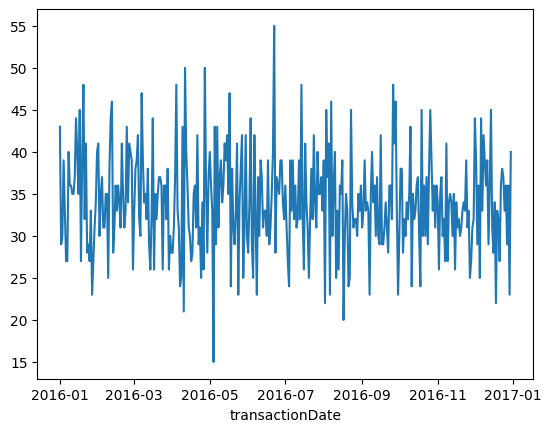

In [25]:
# Visualizing the fraud transaction count 

fraud_wrt_date.plot()

> Above plot shows 

minimum count of fraud transaction = 15
maximum count of fraud transaciion = 55

> This visualisation is important as we want to see if fraud transaction happen daily for there is certain time when they occur more

> This is inline with the expectation that it's a random process

> We will split the train and test data accordingly as we try to **predict for future transactions** if they are Fraud are not

### Extracting other information from transaction date time column

In [26]:
df['trans_month'] = df['transactionDateTime'].dt.month
df['trans_day'] = df['transactionDateTime'].dt.day
df['trans_hour'] = df['transactionDateTime'].dt.hour
df['trans_minute'] = df['transactionDateTime'].dt.minute
df['trans_second'] = df['transactionDateTime'].dt.second

df['trans_week'] = df['transactionDateTime'].dt.week
df['trans_dayofweek'] = df['transactionDateTime'].dt.dayofweek
df['trans_dayofyear'] = df['transactionDateTime'].dt.dayofyear
# could have high number of transaction therefore high fraud chances
df['trans_is_month_start'] = df['transactionDateTime'].dt.is_month_start.astype(int)
df['trans_is_month_end'] = df['transactionDateTime'].dt.is_month_end.astype(int)


In [27]:
df.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,PURCHASE,0.0,0,0,0,0,518,518,2482,8,13,14,27,32,32,5,226,0,0
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,PURCHASE,0.0,1,0,0,0,577,577,2668,10,11,5,5,54,41,1,285,0,0
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,0,0,0,0,605,605,3187,11,8,9,18,39,45,1,313,0,0
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,0,0,0,0,637,637,3155,12,10,2,14,50,49,5,345,0,0
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,PURCHASE,0.0,1,0,0,0,231,231,4938,3,24,21,4,46,12,3,84,0,0


In [28]:
df_transactionDateTime_sort = df.sort_values(by='transactionDateTime').reset_index(drop=True)

df_transactionDateTime_sort.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end
0,419104777,50000,50000.0,2016-01-01 00:01:02,44.09,Washington Post,US,US,09,01,subscriptions,PURCHASE,0.0,0,0,0,0,216,216,4442,1,1,0,1,2,53,4,1,1,0
1,674577133,5000,5000.0,2016-01-01 00:01:44,329.57,staples.com,US,US,09,08,online_retail,PURCHASE,0.0,0,0,0,0,135,135,3195,1,1,0,1,44,53,4,1,1,0
2,958438658,20000,20000.0,2016-01-01 00:01:47,164.57,cheapfast.com,US,US,05,01,online_retail,PURCHASE,0.0,0,0,0,0,895,895,2646,1,1,0,1,47,53,4,1,1,0
3,851126461,10000,10000.0,2016-01-01 00:02:04,122.83,discount.com,US,US,02,08,online_retail,PURCHASE,0.0,0,0,0,0,440,440,3468,1,1,0,2,4,53,4,1,1,0
4,148963316,2500,2500.0,2016-01-01 00:02:19,0.00,Fast Repair,US,US,05,01,auto,ADDRESS_VERIFICATION,0.0,0,0,0,0,750,750,3986,1,1,0,2,19,53,4,1,1,0


In [29]:
df_transactionDateTime_sort.tail()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end
786358,690351684,7500,6007.68,2016-12-30 23:57:33,128.84,EZ Putt Putt #551896,US,US,09,01,entertainment,PURCHASE,1492.32,1,0,0,0,673,673,5814,12,30,23,57,33,52,4,365,0,0
786359,365766122,7500,970.87,2016-12-30 23:58:25,49.47,alibaba.com,US,US,90,01,online_retail,PURCHASE,6529.13,0,0,0,0,711,85,4930,12,30,23,58,25,52,4,365,0,0
786360,543902721,1000,767.70,2016-12-30 23:59:33,13.02,abc.com,US,US,05,08,online_subscriptions,PURCHASE,232.30,0,0,0,0,1784,1784,2223,12,30,23,59,33,52,4,365,0,0
786361,912493707,5000,4991.10,2016-12-30 23:59:35,8.85,Play Store,US,US,09,08,mobileapps,PURCHASE,8.90,0,0,0,0,1554,60,4078,12,30,23,59,35,52,4,365,0,0
786362,152973583,15000,7195.76,2016-12-30 23:59:45,169.07,Burger King #06782,US,US,09,01,fastfood,PURCHASE,7804.24,1,0,0,0,767,133,1248,12,30,23,59,45,52,4,365,0,0


In [30]:
## dropping transaction date time as it's not required for modelling 
# (since the date has been sorted based on it and other relevant infomation has been extracted)

df_transactionDateTime_sort = df_transactionDateTime_sort.drop('transactionDateTime',axis = 1)

In [31]:
# switching cols for ease of usage later

x_feat_col = [col for col in df_transactionDateTime_sort.columns if col != 'isFraud']
y_col = ['isFraud']

df_transactionDateTime_sort.columns = x_feat_col+y_col


df_transactionDateTime_sort.head()

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
0,419104777,50000,50000.0,44.09,Washington Post,US,US,09,01,subscriptions,PURCHASE,0.0,0,0,0,0,216,216,4442,1,1,0,1,2,53,4,1,1,0
1,674577133,5000,5000.0,329.57,staples.com,US,US,09,08,online_retail,PURCHASE,0.0,0,0,0,0,135,135,3195,1,1,0,1,44,53,4,1,1,0
2,958438658,20000,20000.0,164.57,cheapfast.com,US,US,05,01,online_retail,PURCHASE,0.0,0,0,0,0,895,895,2646,1,1,0,1,47,53,4,1,1,0
3,851126461,10000,10000.0,122.83,discount.com,US,US,02,08,online_retail,PURCHASE,0.0,0,0,0,0,440,440,3468,1,1,0,2,4,53,4,1,1,0
4,148963316,2500,2500.0,0.00,Fast Repair,US,US,05,01,auto,ADDRESS_VERIFICATION,0.0,0,0,0,0,750,750,3986,1,1,0,2,19,53,4,1,1,0


# Data preparation for modelling

> Train test split ratio - 80% vs 20%

> **Point to note here** is data is splitted in a time series format that is, recent transactions are in test set and earlier transactions are in train val set as we intend to predict on new trasaction if they are fraud or not

> Also the count of fraud transactions grouped on the basis of date showed that every day there are atleat 15 fraud transactions **so stratified sampling is not required**

In [139]:
## 80-20 train_val test split

train_val_set,test_set = df_transactionDateTime_sort[:(2*len(df))//3],df_transactionDateTime_sort[(2*len(df))//3:]

len(train_val_set),len(test_set)

(524242, 262121)

In [140]:
train_val_set.head()

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
0,419104777,50000,50000.0,44.09,Washington Post,US,US,09,01,subscriptions,PURCHASE,0.0,0,0,0,0,216,216,4442,1,1,0,1,2,53,4,1,1,0
1,674577133,5000,5000.0,329.57,staples.com,US,US,09,08,online_retail,PURCHASE,0.0,0,0,0,0,135,135,3195,1,1,0,1,44,53,4,1,1,0
2,958438658,20000,20000.0,164.57,cheapfast.com,US,US,05,01,online_retail,PURCHASE,0.0,0,0,0,0,895,895,2646,1,1,0,1,47,53,4,1,1,0
3,851126461,10000,10000.0,122.83,discount.com,US,US,02,08,online_retail,PURCHASE,0.0,0,0,0,0,440,440,3468,1,1,0,2,4,53,4,1,1,0
4,148963316,2500,2500.0,0.00,Fast Repair,US,US,05,01,auto,ADDRESS_VERIFICATION,0.0,0,0,0,0,750,750,3986,1,1,0,2,19,53,4,1,1,0


In [141]:
label_encoding_cols  =  list(train_val_set.select_dtypes(include='object').columns)

label_encoding_cols

['merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType']

## Train val split strategy

Out of the train_val set (which is 80 % of the whole data)


Three set are created  [Side note - 20% of whole data (test set) = 25% of train_val data]

> Set 1 : train_1 (1st 25% of whole 80%) val_1 (next 25% of whole 80%)

> Set 2 : train_2 (1st 50% of whole 80%) val_2 (next 25% of whole 80%)

> Set 3 : train_3 (1st 75% of whole 80%) val_3 (last 25% of whole 80%)

In [142]:
# doing multiple train val splits

train_1,val_1 = train_val_set[:(len(train_val_set))//4],train_val_set[(len(train_val_set))//4:(2*len(train_val_set))//4]
train_2,val_2 = train_val_set[:(2*len(train_val_set))//4],train_val_set[(2*len(train_val_set))//4:(3*len(train_val_set))//4]
train_3,val_3 = train_val_set[:(3*len(train_val_set))//4],train_val_set[(3*len(train_val_set))//4:]


len(train_1),len(val_1),len(train_2),len(val_2),len(train_3),len(val_3)

(131060, 131061, 262121, 131060, 393181, 131061)

## Model ready dataset (mrd) Preparation

### Label encoding different sets (with required customization)

In [143]:
# label encoding ACCOUNT NUMBER as we want to FLAG transactions which had fraud transactions earlier

def label_encode(train_set,pred_set):
    '''
    Takes train set and prediction set. Learns the encoding from the train set and applies 
    them on the train and pred set
    
    
    This function also takes in the account number of train set (which had fraud transactions) and Flags them
    IF the account number had history of fraud transaction
    
    '''

    label_encode_di = defaultdict(dict)
    label_encode_count_di = defaultdict(int)

    # preparing the label_encoders
    for col in label_encoding_cols:

        col_di = label_encode_di[col+'_di']

        for col_value in train_set[col].values: 

            if col_value not in col_di:                     
                col_di[col_value] = label_encode_count_di[col]
                label_encode_count_di[col] += 1

    # lable encoding train set            
    for col in label_encoding_cols:    
        train_set[col] =  train_set[col].map(label_encode_di[col+'_di'])  

    # lable encoding test set
    for col in label_encoding_cols:    
        pred_set[col] =  pred_set[col].map(label_encode_di[col+'_di'])  

    # learning account numbers which had fraud transactions earlier
    fraud_history_acc_num = set()
    for acc,flag in train_set[['accountNumber','isFraud']].values:
        if flag == 1:
            fraud_history_acc_num.add(acc)


    # creating flag for previous fraud hist transaction - Train set
    train_set['accountNumber'] = [1 if acc in fraud_history_acc_num else 0 for acc in train_set['accountNumber'].values]

    # creating flag for previous fraud hist transaction - Test set
    pred_set['accountNumber'] = [1 if acc in fraud_history_acc_num else 0 for acc in pred_set['accountNumber'].values]

    train_set.rename(columns = {"accountNumber":"accountNumberFlag"},inplace = True)
    pred_set.rename(columns = {"accountNumber":"accountNumberFlag"},inplace = True)
    
    return train_set,pred_set

In [144]:
train_1,val_1 = label_encode(train_1,val_1)
train_2,val_2 = label_encode(train_2,val_2)
train_3,val_3 = label_encode(train_3,val_3)

train_val_set,test_set = label_encode(train_val_set,test_set)

train_val_set.head()

,accountNumberFlag,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
0,1,50000,50000.0,44.09,0,0,0,0,0,0,0,0.0,0,0,0,0,216,216,4442,1,1,0,1,2,53,4,1,1,0
1,1,5000,5000.0,329.57,1,0,0,0,1,1,0,0.0,0,0,0,0,135,135,3195,1,1,0,1,44,53,4,1,1,0
2,1,20000,20000.0,164.57,2,0,0,1,0,1,0,0.0,0,0,0,0,895,895,2646,1,1,0,1,47,53,4,1,1,0
3,1,10000,10000.0,122.83,3,0,0,2,1,1,0,0.0,0,0,0,0,440,440,3468,1,1,0,2,4,53,4,1,1,0
4,1,2500,2500.0,0.00,4,0,0,1,0,2,1,0.0,0,0,0,0,750,750,3986,1,1,0,2,19,53,4,1,1,0


In [145]:
test_set.head()

,accountNumberFlag,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
524242,1,250,85.09,2.35,9.0,0,0,1,1,5,0,164.91,0,0,0,0,419,226,2093,9,6,2,50,45,36,1,250,0,0
524243,1,5000,1899.90,100.90,298.0,0,0,0,0,0,0,3100.10,0,0,0,0,626,626,1636,9,6,2,51,19,36,1,250,0,0
524244,0,5000,5000.00,162.32,117.0,0,0,0,0,6,0,0.00,1,0,0,0,2876,2876,5715,9,6,2,53,29,36,1,250,0,0
524245,0,500,500.00,229.60,524.0,0,0,1,3,0,0,0.00,1,0,0,0,623,623,2246,9,6,2,53,47,36,1,250,0,0
524246,1,5000,4986.40,34.67,2379.0,0,0,0,0,14,0,13.60,1,0,0,0,493,493,5746,9,6,2,54,1,36,1,250,0,0


In [146]:
val_1.isna().sum()[val_1.isna().sum() > 0]

merchantName    168
dtype: int64

In [147]:
val_2.isna().sum()[val_2.isna().sum() > 0]

merchantName    60
dtype: int64

In [148]:
val_3.isna().sum()[val_3.isna().sum() > 0]

merchantName    36
dtype: int64

In [149]:
test_set.isna().sum()[test_set.isna().sum() > 0]

merchantName    127
dtype: int64

### Imputing na values with -1

In [150]:
val_1['merchantName'].fillna(value = -1,inplace = True)

val_1.isna().sum()[val_1.isna().sum() > 0]

Series([], dtype: int64)

In [151]:
val_2['merchantName'].fillna(value = -1,inplace = True)
val_2.isna().sum()[val_2.isna().sum() > 0]

Series([], dtype: int64)

In [152]:
val_3['merchantName'].fillna(value = -1,inplace = True)
val_3.isna().sum()[val_3.isna().sum() > 0]

Series([], dtype: int64)

In [153]:
test_set['merchantName'].fillna(value = -1,inplace = True)
test_set.isna().sum()[test_set.isna().sum() > 0]

Series([], dtype: int64)

### Checking data imbalance

In [154]:
train_val_set['isFraud'].sum()/len(train_val_set)

0.03168765570099305

> This shows that the training set would be unbalanced therefore need to undersample the data

## Under sampling (imbalance dataset)

In [155]:
import gc

gc.collect()

0

In [156]:
def undersample(df_under):
    
    pos_set = df_under[df_under['isFraud']>0]
    neg_set = df_under[df_under['isFraud'] == 0 ] 
    
    neg_set = neg_set.sample(n= int(len(pos_set)*0.7))
    
    return  pd.concat([pos_set,neg_set])


In [157]:
train_1 = undersample(train_1)
train_2 = undersample(train_2)
train_3 = undersample(train_3)

train_val_set = undersample(train_val_set)

In [158]:
# checking the data imbalance

train_1['isFraud'].sum()/len(train_1),train_2['isFraud'].sum()/len(train_2),train_3['isFraud'].sum()/len(train_3)

(0.588252612983954, 0.5882567735339225, 0.5882578113785348)

In [162]:
train_1.tail()

,accountNumberFlag,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
42047,1,5000,867.45,153.97,1827,0,0,2,0,4,0,4132.55,1,0,0,0,1200,4,3935,1,22,4,28,39,3,4,22,0,0
94132,1,10000,7223.31,6.59,1685,0,0,2,1,4,0,2776.69,1,0,0,0,784,11,2629,2,17,0,53,9,7,2,48,0,0
23578,0,1000,1000.00,211.53,436,0,0,1,1,8,0,0.00,1,0,0,0,239,239,4857,1,12,23,33,23,2,1,12,0,0
15003,1,15000,12200.67,102.37,64,0,0,1,0,1,0,2799.33,0,0,0,0,246,246,4496,1,8,16,1,28,1,4,8,0,0
95207,1,10000,8500.93,271.56,574,0,0,2,0,10,0,1499.07,1,0,0,0,496,496,2175,2,17,13,35,27,7,2,48,0,0


In [163]:
train_2.tail()

,accountNumberFlag,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,mismatchCVV,time_since_acc_open,time_since_add_change,time_remaing_exp,trans_month,trans_day,trans_hour,trans_minute,trans_second,trans_week,trans_dayofweek,trans_dayofyear,trans_is_month_start,trans_is_month_end,isFraud
96620,0,1000,1000.00,508.87,133,0,0,2,0,6,0,0.00,1,0,0,0,988,988,3724,2,18,5,17,31,7,3,49,0,0
99633,1,500,82.58,429.12,180,0,0,1,0,8,0,417.42,1,0,0,0,302,302,6038,2,19,17,42,52,7,4,50,0,0
155511,1,5000,3659.11,141.89,1238,0,0,0,0,4,0,1340.89,1,0,0,0,1777,1777,5827,3,17,22,52,46,11,3,77,0,0
255103,0,15000,15000.00,18.16,172,0,0,1,1,0,0,0.00,1,0,0,0,210,210,3771,5,4,20,23,36,18,2,125,0,0
112083,1,15000,7876.80,22.88,38,0,0,1,0,1,0,7123.20,0,0,0,0,258,258,3717,2,25,18,56,28,8,3,56,0,0


In [164]:
val_1['isFraud'].sum()/len(val_1),val_2['isFraud'].sum()/len(val_2),val_3['isFraud'].sum()/len(val_3)

(0.03097031153432371, 0.032343964596368076, 0.03294649056546189)

In [165]:
val_1 = undersample(val_1)
val_2 = undersample(val_2)
val_3 = undersample(val_3)

test_set = undersample(test_set)

In [166]:
val_1['isFraud'].sum()/len(val_1),val_2['isFraud'].sum()/len(val_2),val_3['isFraud'].sum()/len(val_3)

(0.5882608695652174, 0.5882597835137385, 0.588283378746594)

In [167]:
test_set['isFraud'].sum()/len(test_set)

0.5882656572608397

# Modelling

# Random forest - baseline (default parameters)

In [168]:
rf_baseline = RandomForestClassifier().fit(train_3.iloc[:,:-1],train_3.iloc[:,-1])

In [169]:
pred_probs = rf_baseline.predict_proba(val_3.iloc[:,:-1])

roc_auc_score(val_3.iloc[:,-1], pred_probs[:,1])

0.9777757231284308

In [174]:
pred_probs = rf_baseline.predict_proba(test_set.iloc[:,:-1])

roc_auc_score(test_set.iloc[:,-1], pred_probs[:,1])

0.9876488495559645

In [175]:
rf_baseline.feature_importances_

array([1.84382792e-02, 4.19593764e-04, 1.38429896e-03, 8.17709057e-04,
       7.23641419e-04, 3.52120037e-05, 2.00003665e-05, 2.46874846e-04,
       1.14168692e-04, 4.96634523e-04, 7.13292415e-05, 2.33333939e-03,
       8.68828569e-05, 6.41025610e-06, 4.59716080e-05, 2.79857025e-05,
       1.27356180e-03, 1.24013683e-03, 1.03233712e-03, 2.53197851e-02,
       7.82840212e-01, 5.14994287e-04, 4.81293272e-04, 5.22998269e-04,
       5.30089132e-02, 3.22638299e-02, 7.08597775e-02, 5.37382852e-03])

In [176]:
pd.DataFrame(sorted(zip(rf_baseline.feature_importances_,list(train_3.columns)[:-1]),reverse=True), columns=['Value','Feature'])

,Value,Feature
0,0.782840,trans_hour
1,0.070860,trans_is_month_start
2,0.053009,trans_dayofweek
3,0.032264,trans_dayofyear
4,0.025320,trans_day
5,0.018438,accountNumberFlag
6,0.005374,trans_is_month_end
7,0.002333,currentBalance
8,0.001384,availableMoney
9,0.001274,time_since_add_change


In [173]:
print(classification_report(test_set.iloc[:,-1], rf_baseline.predict(test_set.iloc[:,:-1])))

              precision    recall  f1-score   support

           0       0.64      0.98      0.77      4786
           1       0.98      0.61      0.75      6838

    accuracy                           0.76     11624
   macro avg       0.81      0.80      0.76     11624
weighted avg       0.84      0.76      0.76     11624



## LGBM - baseline (default parameters)

In [177]:
## WITH default parameter training on the train_3 set and predicting on val_3 and test set


model_baseline = LGBMClassifier().fit(train_3.iloc[:,:-1],train_3.iloc[:,-1])

In [178]:
pred_probs = model_baseline.predict_proba(val_3.iloc[:,:-1])

roc_auc_score(val_3.iloc[:,-1], pred_probs[:,1])

0.9835626434401544

In [179]:
pred_probs = model_baseline.predict_proba(test_set.iloc[:,:-1])

roc_auc_score(test_set.iloc[:,-1], pred_probs[:,1])

0.9869006829537306

In [180]:
pd.DataFrame(sorted(zip(model_baseline.feature_importances_,list(train_3.columns)[:-1]),reverse=True), columns=['Value','Feature'])

,Value,Feature
0,497,availableMoney
1,278,creditLimit
2,218,transactionAmount
3,208,trans_hour
4,202,trans_is_month_start
5,192,trans_day
6,105,accountNumberFlag
7,100,trans_dayofyear
8,57,merchantName
9,19,time_since_add_change


In [181]:
print(classification_report(test_set.iloc[:,-1], model_baseline.predict(test_set.iloc[:,:-1])))

              precision    recall  f1-score   support

           0       0.64      0.98      0.77      4786
           1       0.98      0.61      0.75      6838

    accuracy                           0.76     11624
   macro avg       0.81      0.80      0.76     11624
weighted avg       0.84      0.76      0.76     11624

